# Text Diversity Metric based on Contextualized Word Embeddings

Helpful resources:
1. [Measuring the diversity of a single community](http://www.loujost.com/Statistics%20and%20Physics/Diversity%20and%20Similarity/Diversity%20of%20a%20single%20community.htm)
2. [Diversity analysis: a fresh approach](http://www.loujost.com/Statistics%20and%20Physics/Diversity%20and%20Similarity/SampleChapter.pdf)
3. [Entropy and diversity](http://www.loujost.com/Statistics%20and%20Physics/Diversity%20and%20Similarity/JostEntropy%20AndDiversity.pdf)
4. [Measuring diversity: the importance of species similarity](https://esajournals.onlinelibrary.wiley.com/doi/pdf/10.1890/10-2402.1?casa_token=mbrErMtraXsAAAAA:Ltv-lIElB2OEFqouF8Y0p4B9MsF4NVAeGhB5xZ0Q50Hv4DQwYoyC7Sz37Wv-XnAiMP2xHxnkvp2LCA)***

In [ ]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 1.8MB 17.3MB/s 
     |████████████████████████████████| 2.9MB 49.3MB/s 
     |████████████████████████████████| 890kB 50.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ee97c3ddd6331f664e27f2179f0803e09acd51c60a7e2adf9120d84eb87bd13a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 163kB 22.9MB/s 
     |████████████████████████████████| 17.7MB 210kB/s 
     |████████████████████████████████| 245kB 58.4MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [ ]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from sklearn.decomposition import PCA
from scipy import spatial
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm
import pprint

import seaborn as sns 
import matplotlib.pyplot as plt

sns.set("paper", rc={"font.size":20,
                     "axes.titlesize":25,
                     "axes.labelsize":20,
                     "lines.linewidth":2,
                     "lines.markersize":5,
                     "xtick.labelsize":14,
                     "ytick.labelsize":14}) 

sns.set_style("white")
plt.rc("axes", labelweight="normal")

np.set_printoptions(precision=2, suppress=True)
pp = pprint.PrettyPrinter(width=120)

In [ ]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [ ]:
class TextDiversity:
    def __init__(self, 
                 MODEL_NAME="bert-base-uncased", 
                 batch_size=16, 
                 use_gpu=True, 
                 verbose=False):
        self.MODEL_NAME = MODEL_NAME
        self.model = AutoModel.from_pretrained(MODEL_NAME)
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.undesirable_tokens = [
            self.tokenizer.pad_token_id, 
            self.tokenizer.cls_token_id, 
            self.tokenizer.sep_token_id
        ]
        self.batch_size = batch_size
        self.use_gpu = use_gpu
        self.device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
        self.verbose = verbose

        self.tokens = None
        self.token_similarities = None
        self.bag_of_embeddings = None

        # move model to device
        self.model.to(self.device)
    
    def __call__(self, 
                 corpus, 
                 q=1, 
                 distance_fn=None, 
                 n_components=2, 
                 normalize=False, 
                 ignore_similarities=False):
        
        # get bag_of_embeddings (boe) from model + tokens
        boe, tok = self.get_embeddings(corpus, n_components)

        # get similarity matrix (Z)
        Z = self.get_token_similarities(boe, distance_fn)
        
        # get diversity
        num_tok = len(tok)
        p = np.full(num_tok, 1/num_tok)
        D = self.get_diversity(p, Z, q, normalize, ignore_similarities)

        if self.verbose:
            ret = {
                'diversity': D,
                'entropy': np.log(D),
                'tokens': self.tokens,
                'token_similarities': self.token_similarities,
                'bag_of_embeddings': self.bag_of_embeddings
            } 
        else:
            ret = {
                'diversity': D
            }    
        
        return ret

    def encode(self, input_ids, attention_mask):
        self.model.eval()
        with torch.no_grad():
            out = self.model(input_ids, attention_mask=attention_mask)
        emb = out[0]
        return emb

    def get_embeddings(self, corpus, n_components=2):
        # TODO: figure out how to handle BPE breakdown
        #       of single word into multiple token_ids
        inputs = self.tokenizer(corpus, return_tensors='pt', padding=True, truncation=True)
        batches = zip(chunker(inputs.input_ids, self.batch_size), 
                      chunker(inputs.attention_mask, self.batch_size))
        if self.verbose:
            print('getting token embeddings...')
            batches = tqdm(batches, total=int(len(inputs.input_ids)/self.batch_size))
        outputs = []
        for input_ids, attention_mask in batches:
          emb = self.encode(input_ids.to(self.device), 
                       attention_mask.to(self.device))
          outputs.append(emb)
        embeddings = torch.cat(outputs)

        idx = np.isin(inputs['input_ids'],  self.undesirable_tokens, assume_unique=True, invert=True).reshape(-1)
        tok = np.array(self.tokenizer.convert_ids_to_tokens(inputs.input_ids.view(-1)))[idx]
        boe = embeddings.view(-1, embeddings.shape[-1])[idx].detach().cpu()

        # compress embedding to speed up similarity matrix computation
        if type(n_components) == int and n_components > 0 and len(boe) > 1:
            boe = PCA(n_components=n_components).fit_transform(boe)

        self.tokens = tok
        self.bag_of_embeddings = boe

        return boe, tok

    def get_token_similarities(self, boe, dist_fn=None):
        if dist_fn is None:
            dist_fn = spatial.distance.chebyshev  

        num_embeddings = len(boe)

        tok_sims = np.ones((num_embeddings, num_embeddings))
        iu = np.triu_indices(num_embeddings, k=1)
        il = (iu[1], iu[0])

        iterable = range(num_embeddings)
        if self.verbose:
            print('calculating similarity matrix...')
            iterable = tqdm(iterable)

        for e1 in iterable:
            for e2 in range(1, num_embeddings - e1):
                d = dist_fn(boe[e1], boe[e1 + e2])
                scaled_d = np.exp(-d)
                tok_sims[e1][e1 + e2] = scaled_d        
        tok_sims[il] = tok_sims[iu]

        self.token_similarities = tok_sims

        return tok_sims    

    def get_diversity(self, p, Z, q=1, normalize=False, ignore_similarities=False):
        if ignore_similarities:
            Z = np.eye(len(Z))
        Zp =  Z @ p
        if q == 1:
            D = 1 / np.prod(Zp ** p)
        elif q == np.inf:
            D = 1 / Zp.max()
        else:
            D = (p * Zp ** (q-1)).sum() ** (1/(1-q))
        if normalize:
            D /= len(p)
        return D    

    def get_diversity_profile(self, 
                              corpus, 
                              distance_fn=None, 
                              n_components=2, 
                              normalize=False, 
                              ignore_similarities=False, 
                              range=None):
        # get bag_of_embeddings (boe) from model + tokens
        boe, tok = self.get_embeddings(corpus, n_components)

        # get similarity matrix (Z)
        Z = self.get_token_similarities(boe, distance_fn)

        # plot diversity profile
        num_tok = len(tok)
        p = np.full(num_tok, 1/num_tok)
        
        if range is None:
            range = np.arange(0, 101)
        Ds = []
        for q in range:
            D = self.get_diversity(p, Z, q, normalize)
            Ds.append(D)
        ax = sns.lineplot(x=range, y=Ds)  
        ax.set(xlabel="Sensitivity Parameter, $q$", 
               ylabel="Diversity $^qD(\mathbf{p})$" if ignore_similarities else "Diversity $^qD^{\mathbf{Z}}(\mathbf{p})$", 
               title="Corpus Diversity Profile")
        plt.show()

In [ ]:
diversity_metric = TextDiversity(verbose=False)

In [ ]:
corpus1 = [
    'python is hard',
    'a python slithering',
    'jokes be funny'
]

corpus2 = [
    'The celestial orb is red',
    'The star is orange',
    'The sun is yellow'
]

train = load_dataset('glue', 'sst2')['train']
train.rename_column_('sentence', 'text')

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4. Subsequent calls will reuse this data.


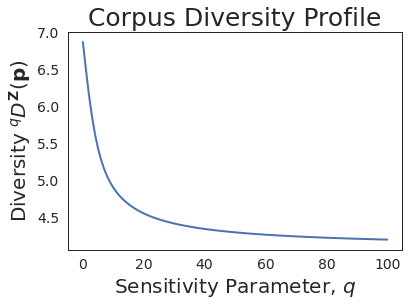

In [ ]:
diversity_metric.get_diversity_profile(corpus2)

In [ ]:
pp.pprint(corpus1)
pp.pprint(diversity_metric(corpus1, q=1))

print()

pp.pprint(corpus2)
pp.pprint(diversity_metric(corpus2, q=1))

# n = np.random.randint(0, len(train['text']), 20)
# corpus3 = np.array(train['text'])[n].tolist()
# # pp.pprint(corpus3)
# pp.pprint(diversity_metric(corpus3))

['python is hard', 'a python slithering', 'jokes be funny']
{'diversity': 7.950970518643307}

['The celestial orb is red', 'The star is orange', 'The sun is yellow']
{'diversity': 6.502533921158239}


In [ ]:
for _ in range(10):
    i = np.random.randint(0, len(train['text']), 1)
    corpus = np.array(train['text'])[i].tolist()
    print(corpus[0])
    print('diveristy:', diversity_metric(corpus))
    print()

In [ ]:
max_dist = 0
obj = ()
for dist_fn in distance_fns:
  for n_components in range(1, 11):
    c1_div = round(metric(corpus1, dist_fn, n_components), 4)
    c2_div = round(metric(corpus2, dist_fn, n_components), 4)
    dist = round(c1_div - c2_div, 4)
    if dist > max_dist:
        max_dist = dist
        obj = (dist_fn.__name__, n_components)
    print(dist_fn.__name__, n_components, c1_div, c2_div, dist)
print(max_dist, obj)

# Development Area
Non-object code

In [ ]:
# Store the model we want to use
MODEL_NAME = "bert-base-uncased"
batch_size = 10

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

undesirable_tokens = [
            tokenizer.pad_token_id, 
            tokenizer.cls_token_id, 
            tokenizer.sep_token_id
        ]

In [ ]:
inputs = tokenizer(corpus2, return_tensors='pt', padding=True)
embeddings = get_embeddings(inputs)

In [ ]:
idx = np.isin(inputs['input_ids'], undesirable_tokens, assume_unique=True, invert=True).reshape(-1)
tok = np.array(tokenizer.convert_ids_to_tokens(inputs.input_ids.view(-1)))[idx]
boe = embeddings.view(-1, embeddings.shape[-1])[idx].detach()

n_components = 2
if type(n_components) == int and n_components > 0:
    boe = PCA(n_components=n_components).fit_transform(boe)

In [ ]:
freq = np.full(boe.shape[0], 1/boe.shape[0])
e_sim = get_token_similarities(boe)
eff_e_sim = freq @ e_sim
H = -(freq * np.log(eff_e_sim)).sum()
diversity = np.exp(H)

In [ ]:
diversity, diversity/len(tok)

(6.502530591271502, 0.5001946608670387)

In [ ]:
tok.shape

(10,)

## Which distance gives good results?

In [ ]:
from scipy.stats import wasserstein_distance
from scipy import spatial

distance_fns = [
  spatial.distance.braycurtis,
  spatial.distance.canberra,
  spatial.distance.chebyshev,
  spatial.distance.cityblock,
  spatial.distance.correlation,
  spatial.distance.cosine,
  spatial.distance.euclidean,
  spatial.distance.jensenshannon,
  # spatial.distance.mahalanobis,
  spatial.distance.minkowski,
  # spatial.distance.seuclidean,
  # spatial.distance.sqeuclidean,
  # spatial.distance.wminkowski,
  wasserstein_distance
]

print(corpus1, boe)
for dist_fn in distance_fns:
  print(dist_fn.__name__)
  e_dists = get_token_similarities(boe, dist_fn)
  print(e_dists)

['I am a thug', 'You are a thug', 'We are thugs'] [[-3.28 -0.69]
 [-6.22 -3.05]
 [-0.51 -3.53]
 [ 4.93 -3.94]
 [ 0.44 10.1 ]
 [-6.98 -0.97]
 [-1.08 -2.59]
 [ 7.34 -2.64]
 [ 2.03  9.18]
 [-5.05  0.09]
 [ 8.38 -1.96]]
braycurtis
[[1.   0.67 0.5  0.16 0.31 0.72 0.59 0.18 0.21 0.75 0.19]
 [0.67 1.   0.63 0.23 0.21 0.85 0.65 0.13 0.14 0.74 0.11]
 [0.5  0.63 1.   0.61 0.11 0.47 0.82 0.51 0.12 0.4  0.46]
 [0.16 0.23 0.61 1.   0.2  0.12 0.49 0.82 0.27 0.03 0.75]
 [0.31 0.21 0.11 0.2  1.   0.31 0.17 0.28 0.89 0.35 0.31]
 [0.72 0.85 0.47 0.12 0.31 1.   0.52 0.02 0.23 0.79 0.02]
 [0.59 0.65 0.82 0.49 0.17 0.52 1.   0.48 0.14 0.46 0.43]
 [0.18 0.13 0.51 0.82 0.28 0.02 0.48 1.   0.34 0.04 0.92]
 [0.21 0.14 0.12 0.27 0.89 0.23 0.14 0.34 1.   0.27 0.37]
 [0.75 0.74 0.4  0.03 0.35 0.79 0.46 0.04 0.27 1.   0.05]
 [0.19 0.11 0.46 0.75 0.31 0.02 0.43 0.92 0.37 0.05 1.  ]]
canberra
[[1.   0.39 0.25 0.18 0.14 0.59 0.34 0.2  0.14 0.3  0.23]
 [0.39 1.   0.4  0.32 0.14 0.56 0.46 0.34 0.14 0.33 0.3 ]
 [0.25 0.

In [ ]:
print(corpus2, boe)
for dist_fn in distance_fns:
  print(dist_fn.__name__)
  e_dists = get_token_similarities(boe, dist_fn)
  print(e_dists)

['The sun is red', 'The sun is orange', 'The sun is yellow'] [[-4.47 -5.13]
 [ 9.65  0.36]
 [-1.67 -3.96]
 [-3.83  8.2 ]
 [-4.41 -5.21]
 [ 9.89  0.37]
 [-1.61 -3.52]
 [-3.38  8.65]
 [-4.38 -5.52]
 [ 9.64  0.16]
 [-1.59 -3.85]
 [-3.85  9.45]]
braycurtis
[[1.   0.14 0.77 0.29 0.99 0.14 0.74 0.27 0.98 0.15 0.76 0.3 ]
 [0.14 1.   0.26 0.23 0.14 0.99 0.26 0.25 0.15 0.99 0.26 0.24]
 [0.77 0.26 1.   0.23 0.77 0.26 0.95 0.23 0.76 0.27 0.98 0.24]
 [0.29 0.23 0.23 1.   0.29 0.23 0.25 0.96 0.27 0.22 0.23 0.95]
 [0.99 0.14 0.77 0.29 1.   0.15 0.74 0.27 0.98 0.15 0.76 0.3 ]
 [0.14 0.99 0.26 0.23 0.15 1.   0.26 0.25 0.15 0.98 0.26 0.24]
 [0.74 0.26 0.95 0.25 0.74 0.26 1.   0.25 0.73 0.27 0.97 0.26]
 [0.27 0.25 0.23 0.96 0.27 0.25 0.25 1.   0.25 0.24 0.23 0.95]
 [0.98 0.15 0.76 0.27 0.98 0.15 0.73 0.25 1.   0.16 0.75 0.28]
 [0.15 0.99 0.27 0.22 0.15 0.98 0.27 0.24 0.16 1.   0.27 0.23]
 [0.76 0.26 0.98 0.23 0.76 0.26 0.97 0.23 0.75 0.27 1.   0.24]
 [0.3  0.24 0.24 0.95 0.3  0.24 0.26 0.95 0.28 0.23 0.

## TFIDF weighting??

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(corpus1)
tfidf = vectorizer.fit(corpus1)
terms = vectorizer.get_feature_names()
print(terms)

['am', 'are', 'thug', 'thugs', 'we', 'you']


In [ ]:
n = '00000010100101000001111010011100'

In [ ]:
n[::-1]

'00111001011110000010100101000000'

In [ ]:
int(n[::-1],2)

964176192

3221225471